In [1]:
file_path='./eq_database/data/'

In [2]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


In [3]:
os.listdir(file_path)

['TF_2019.csv',
 'TF_2018.csv',
 'TS_2021.csv',
 'TS_2020.csv',
 'TS_2018.csv',
 '.DS_Store',
 'TS_2019.csv',
 'TF_2020.csv',
 'TF_2021.csv',
 'T_2015.csv',
 'T_2017.csv',
 'T_2016.csv',
 'T_2021.csv',
 'T_2020.csv',
 'T_2018.csv',
 'T_2019.csv',
 'TF_2013.csv',
 'TF_2016.csv',
 'TF_2017.csv',
 'TF_2015.csv',
 'TF_2014.csv']

In [4]:
df_all=pd.DataFrame(columns=['security_id', 'date', 'time', 'open', 'high',
       'low', 'last', 'total_volume_trade', 'total_value_trade',
       'total_position'])
for year in range(2015,2022):
    file_name='T_{}.csv'.format(year)
    df=pd.read_csv(file_path+file_name,index_col=0)[['security_id', 'date', 'time', 'open', 'high',
       'low', 'last', 'total_volume_trade', 'total_value_trade',
       'total_position']]
    df_all=pd.concat([df_all,df])
df_all.shape

(1006026, 10)

In [5]:
df_all['datetime']= pd.to_datetime(df_all['date'].apply(str)+df_all['time'].apply(str), format='%Y%m%d%H%M00000')
df_all = df_all.set_index(['security_id', 'datetime']).sort_index()
for col in ['open','high','low','last']:
    df_all[col]=df_all[col].astype(int)

In [6]:
df=df_all[['last']]
df.head()

last
security_id datetime                   
T1509       2015-03-20 09:15:00  973349
            2015-03-20 09:16:00  976400
            2015-03-20 09:17:00  974500
            2015-03-20 09:18:00  972750
            2015-03-20 09:19:00  972500

In [7]:
def get_move_storehouse_date(trading_days:list):
    '''构造输入的日期序列的辅助函数
    trading_days 日期序列'''
    
    # 目标移仓日期是交割月份前一个月的 14 日
    target_month_day = ["-02-14", "-05-14", "-08-14","-11-14"]
    start, *_, end = trading_days
    start_year, end_year = start.year, end.year
    
    ret = []
    while start_year <= end_year:
        for md in target_month_day:
            target = pd.to_datetime(str(start_year) + md)
            # 如果构造的目标移仓日期早于日期序列最早，则跳过，晚于同理
            if target >end or target < start:
                continue
            ret.append(target.strftime(r"%Y-%m-%d"))
        start_year = start_year + 1
    
    return ret

def get_move_storehouse_index_slice(move_storehouse_date, gb_type="T"):
    '''构造索引列表的辅助函数
    例如，输入 ['2021-02-14', '2021-05-14']
    则 '2021-02-14' 之前交易 T2103
    '2021-02-15' 至 '2021-05-14' 之间交易 T2106
    '2021-05-15' 之后交易 T2109
    '''
    
    def plus_one_day(str_d):
        d = datetime.strptime(str_d, r"%Y-%m-%d") + timedelta(days=1)
        return d.strftime(r"%Y-%m-%d")
        
    ret = []
    for d in move_storehouse_date:
        gb_num_code = int(d[2:7].replace("-", ""))+1
        ret.append(gb_num_code)
        if d == move_storehouse_date[-1]:
            # 列表中最后一个日期需要把下一个要交易的合约计算出来
            gb_num_code = int(d[2:7].replace("-", ""))+4
            if gb_num_code % 100 == 15:
                # 如果这里 d 是 '2020-11-14'
                # 则 gb_num_code 是 2015
                # -12 + 100 之后变为 2103
                gb_num_code = int(gb_num_code) - 12 + 100
            ret.append(gb_num_code)
    
    # 组装索引切片组
    type_code = [gb_type+str(n) for n in ret]
    slice_list = []
    for i, _ in enumerate(type_code):
        if i == 0:
            slice_list.append(slice(None, move_storehouse_date[0]))
        elif i == len(move_storehouse_date):
            slice_list.append(slice(plus_one_day(move_storehouse_date[-1]), None))
        else:
            slice_list.append(slice(plus_one_day(move_storehouse_date[i-1]), move_storehouse_date[i]))
    return list(zip(type_code, slice_list))



In [8]:
msd = get_move_storehouse_date(df_all.index.levels[1])       
index_slice = get_move_storehouse_index_slice(msd)
# 因为没有T1506合约，将起始合约选择为T1509
index_slice_adj=index_slice[1:]
index_slice_adj[0]=index_slice[1][0],slice(None,index_slice[1][1].stop,None)
msd, index_slice_adj

(['2015-05-14',
  '2015-08-14',
  '2015-11-14',
  '2016-02-14',
  '2016-05-14',
  '2016-08-14',
  '2016-11-14',
  '2017-02-14',
  '2017-05-14',
  '2017-08-14',
  '2017-11-14',
  '2018-02-14',
  '2018-05-14',
  '2018-08-14',
  '2018-11-14',
  '2019-02-14',
  '2019-05-14',
  '2019-08-14',
  '2019-11-14',
  '2020-02-14',
  '2020-05-14',
  '2020-08-14',
  '2020-11-14',
  '2021-02-14',
  '2021-05-14'],
 [('T1509', slice(None, '2015-08-14', None)),
  ('T1512', slice('2015-08-15', '2015-11-14', None)),
  ('T1603', slice('2015-11-15', '2016-02-14', None)),
  ('T1606', slice('2016-02-15', '2016-05-14', None)),
  ('T1609', slice('2016-05-15', '2016-08-14', None)),
  ('T1612', slice('2016-08-15', '2016-11-14', None)),
  ('T1703', slice('2016-11-15', '2017-02-14', None)),
  ('T1706', slice('2017-02-15', '2017-05-14', None)),
  ('T1709', slice('2017-05-15', '2017-08-14', None)),
  ('T1712', slice('2017-08-15', '2017-11-14', None)),
  ('T1803', slice('2017-11-15', '2018-02-14', None)),
  ('T1806', s

In [9]:
df_to_split_joint = []
for security_id, datetime_slice in index_slice_adj:
    df_to_split_joint.append(df_all.loc[security_id][datetime_slice])
df_concat = pd.concat(df_to_split_joint)
df_concat

,date,time,open,high,low,last,total_volume_trade,total_value_trade,total_position
datetime,,,,,,,,,
2015-03-20 09:15:00,20150320,91500000,969000,979599,969000,973349,103,100185050,72
2015-03-20 09:16:00,20150320,91600000,973349,978000,973349,976400,123,120077800,148
2015-03-20 09:17:00,20150320,91700000,976350,976400,974000,974500,68,66320950,170
2015-03-20 09:18:00,20150320,91800000,974050,974050,972200,972750,84,81736000,178
2015-03-20 09:19:00,20150320,91900000,972500,973000,971350,972500,75,72935950,201
...,...,...,...,...,...,...,...,...,...
2021-08-13 15:10:00,20210813,151000000,999050,999100,998950,998950,238,237763300,73929
2021-08-13 15:11:00,20210813,151100000,998950,999000,998900,998900,153,152835450,73857
2021-08-13 15:12:00,20210813,151200000,998900,998900,998800,998800,332,331618600,73684


In [10]:
from typing import Tuple, Union, overload

def get_logrr(close: Union[pd.Series, pd.DataFrame]) -> Union[pd.Series, pd.DataFrame]:
    logrr = np.log(close).diff()[1:]  # type: ignore
    return logrr
logrr = pd.DataFrame(df['last'].apply(int)).groupby('security_id').apply(get_logrr).droplevel(0).rename(columns={"last":"close_rr"})

# log
df_to_split_joint = []
for security_id, datetime_slice in index_slice_adj:
    df_to_split_joint.append(logrr.loc[security_id][datetime_slice])
    
fidf = pd.concat(df_to_split_joint)
fidf

,close_rr
datetime,
2015-03-20 09:16:00,0.003130
2015-03-20 09:17:00,-0.001948
2015-03-20 09:18:00,-0.001797
2015-03-20 09:19:00,-0.000257
2015-03-20 09:20:00,-0.000567
...,...
2021-08-13 15:10:00,-0.000100
2021-08-13 15:11:00,-0.000050
2021-08-13 15:12:00,-0.000100


In [11]:
df_price=(df_concat[['open','high','low','last']]/10000)
# 去除两个异常值点
df_price.loc[df_price[df_price['low']<80].index,'low']=df_price[df_price['low']<80]['last'].tolist()
df_price

,open,high,low,last
datetime,,,,
2015-03-20 09:15:00,96.9000,97.9599,96.9000,97.3349
2015-03-20 09:16:00,97.3349,97.8000,97.3349,97.6400
2015-03-20 09:17:00,97.6350,97.6400,97.4000,97.4500
2015-03-20 09:18:00,97.4050,97.4050,97.2200,97.2750
2015-03-20 09:19:00,97.2500,97.3000,97.1350,97.2500
...,...,...,...,...
2021-08-13 15:10:00,99.9050,99.9100,99.8950,99.8950
2021-08-13 15:11:00,99.8950,99.9000,99.8900,99.8900
2021-08-13 15:12:00,99.8900,99.8900,99.8800,99.8800


In [12]:

start_price=df_price.iloc[0]['last']
close_series=np.exp(fidf.cumsum())*start_price
close_series

,close_rr
datetime,
2015-03-20 09:16:00,97.640000
2015-03-20 09:17:00,97.450000
2015-03-20 09:18:00,97.275000
2015-03-20 09:19:00,97.250000
2015-03-20 09:20:00,97.194900
...,...
2021-08-13 15:10:00,110.440060
2021-08-13 15:11:00,110.434532
2021-08-13 15:12:00,110.423476


In [13]:
mul_fac=close_series['close_rr'].apply(float)/df_price.iloc[1:]['last'].apply(float)


In [14]:
df_price_adj=pd.concat([mul_fac.mul(df_price[x]) for x in df_price.columns],axis=1)
df_price_adj.columns=df_price.columns
df_price_adj=df_price_adj.round(4)
df_price_adj.iloc[0]=df_price.iloc[0]
df_price_adj


,open,high,low,last
datetime,,,,
2015-03-20 09:15:00,96.9000,97.9599,96.9000,97.3349
2015-03-20 09:16:00,97.3349,97.8000,97.3349,97.6400
2015-03-20 09:17:00,97.6350,97.6400,97.4000,97.4500
2015-03-20 09:18:00,97.4050,97.4050,97.2200,97.2750
2015-03-20 09:19:00,97.2500,97.3000,97.1350,97.2500
...,...,...,...,...
2021-08-13 15:10:00,110.4511,110.4566,110.4401,110.4401
2021-08-13 15:11:00,110.4401,110.4456,110.4345,110.4345
2021-08-13 15:12:00,110.4345,110.4345,110.4235,110.4235


In [15]:
df_concat_adj=df_concat.copy()
df_concat_adj.loc[:,['open','high','low','last']]=df_price_adj
df_concat_adj

,date,time,open,high,low,last,total_volume_trade,total_value_trade,total_position
datetime,,,,,,,,,
2015-03-20 09:15:00,20150320,91500000,96.9000,97.9599,96.9000,97.3349,103,100185050,72
2015-03-20 09:16:00,20150320,91600000,97.3349,97.8000,97.3349,97.6400,123,120077800,148
2015-03-20 09:17:00,20150320,91700000,97.6350,97.6400,97.4000,97.4500,68,66320950,170
2015-03-20 09:18:00,20150320,91800000,97.4050,97.4050,97.2200,97.2750,84,81736000,178
2015-03-20 09:19:00,20150320,91900000,97.2500,97.3000,97.1350,97.2500,75,72935950,201
...,...,...,...,...,...,...,...,...,...
2021-08-13 15:10:00,20210813,151000000,110.4511,110.4566,110.4401,110.4401,238,237763300,73929
2021-08-13 15:11:00,20210813,151100000,110.4401,110.4456,110.4345,110.4345,153,152835450,73857
2021-08-13 15:12:00,20210813,151200000,110.4345,110.4345,110.4235,110.4235,332,331618600,73684


In [16]:
df_concat_adj

,date,time,open,high,low,last,total_volume_trade,total_value_trade,total_position
datetime,,,,,,,,,
2015-03-20 09:15:00,20150320,91500000,96.9000,97.9599,96.9000,97.3349,103,100185050,72
2015-03-20 09:16:00,20150320,91600000,97.3349,97.8000,97.3349,97.6400,123,120077800,148
2015-03-20 09:17:00,20150320,91700000,97.6350,97.6400,97.4000,97.4500,68,66320950,170
2015-03-20 09:18:00,20150320,91800000,97.4050,97.4050,97.2200,97.2750,84,81736000,178
2015-03-20 09:19:00,20150320,91900000,97.2500,97.3000,97.1350,97.2500,75,72935950,201
...,...,...,...,...,...,...,...,...,...
2021-08-13 15:10:00,20210813,151000000,110.4511,110.4566,110.4401,110.4401,238,237763300,73929
2021-08-13 15:11:00,20210813,151100000,110.4401,110.4456,110.4345,110.4345,153,152835450,73857
2021-08-13 15:12:00,20210813,151200000,110.4345,110.4345,110.4235,110.4235,332,331618600,73684


In [17]:
df_concat_adj.isna()

,date,time,open,high,low,last,total_volume_trade,total_value_trade,total_position
datetime,,,,,,,,,
2015-03-20 09:15:00,False,False,False,False,False,False,False,False,False
2015-03-20 09:16:00,False,False,False,False,False,False,False,False,False
2015-03-20 09:17:00,False,False,False,False,False,False,False,False,False
2015-03-20 09:18:00,False,False,False,False,False,False,False,False,False
2015-03-20 09:19:00,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
2021-08-13 15:10:00,False,False,False,False,False,False,False,False,False
2021-08-13 15:11:00,False,False,False,False,False,False,False,False,False
2021-08-13 15:12:00,False,False,False,False,False,False,False,False,False


In [18]:
df_concat_adj.isna().describe()

,date,time,open,high,low,last,total_volume_trade,total_value_trade,total_position
count,420664,420664,420664,420664,420664,420664,420664,420664,420664
unique,1,1,1,1,1,1,1,1,2
top,False,False,False,False,False,False,False,False,False
freq,420664,420664,420664,420664,420664,420664,420664,420664,420663


In [19]:
df_concat_adj[df_concat_adj['total_position'].isna()]

,date,time,open,high,low,last,total_volume_trade,total_value_trade,total_position
datetime,,,,,,,,,
2019-11-12 10:31:00,20191112,103100000,104.5988,104.6041,104.5935,104.5988,109,106809400,NaN


In [20]:
def quarter_time(dt):
    return dt-timedelta(minutes=(dt.minute%15 - 15))
quarter_time=df_concat_adj.index.to_series().apply(quarter_time)
quarter_time

datetime
2015-03-20 09:15:00   2015-03-20 09:30:00
2015-03-20 09:16:00   2015-03-20 09:30:00
2015-03-20 09:17:00   2015-03-20 09:30:00
2015-03-20 09:18:00   2015-03-20 09:30:00
2015-03-20 09:19:00   2015-03-20 09:30:00
                              ...        
2021-08-13 15:10:00   2021-08-13 15:15:00
2021-08-13 15:11:00   2021-08-13 15:15:00
2021-08-13 15:12:00   2021-08-13 15:15:00
2021-08-13 15:13:00   2021-08-13 15:15:00
2021-08-13 15:14:00   2021-08-13 15:15:00
Name: datetime, Length: 420664, dtype: datetime64[ns]

In [21]:
df_concat_adj['quarter_time']=quarter_time.tolist()
df_concat_adj

,date,time,open,high,low,last,total_volume_trade,total_value_trade,total_position,quarter_time
datetime,,,,,,,,,,
2015-03-20 09:15:00,20150320,91500000,96.9000,97.9599,96.9000,97.3349,103,100185050,72,2015-03-20 09:30:00
2015-03-20 09:16:00,20150320,91600000,97.3349,97.8000,97.3349,97.6400,123,120077800,148,2015-03-20 09:30:00
2015-03-20 09:17:00,20150320,91700000,97.6350,97.6400,97.4000,97.4500,68,66320950,170,2015-03-20 09:30:00
2015-03-20 09:18:00,20150320,91800000,97.4050,97.4050,97.2200,97.2750,84,81736000,178,2015-03-20 09:30:00
2015-03-20 09:19:00,20150320,91900000,97.2500,97.3000,97.1350,97.2500,75,72935950,201,2015-03-20 09:30:00
...,...,...,...,...,...,...,...,...,...,...
2021-08-13 15:10:00,20210813,151000000,110.4511,110.4566,110.4401,110.4401,238,237763300,73929,2021-08-13 15:15:00
2021-08-13 15:11:00,20210813,151100000,110.4401,110.4456,110.4345,110.4345,153,152835450,73857,2021-08-13 15:15:00
2021-08-13 15:12:00,20210813,151200000,110.4345,110.4345,110.4235,110.4235,332,331618600,73684,2021-08-13 15:15:00


In [22]:
def get_last(series):
    return series.iloc[-1]
def get_first(series):
    return series.iloc[0]
df_quarter=pd.DataFrame()

group=df_concat_adj.groupby('quarter_time')
df_quarter['high']=group['high'].max()
df_quarter['low']=group['low'].min()
df_quarter['open']=group['open'].apply(get_first)
df_quarter['last']=group['last'].apply(get_last)


df_quarter['total_volume_trade']=group['total_volume_trade'].sum() #交易量
df_quarter['total_value_trade']=group['total_value_trade'].sum() # 交易额
df_quarter['total_position']=group['total_position'].apply(get_last) # 持仓量
df_quarter['value_num']=group['last'].count() # 样本数量
df_quarter['std']=group['last'].std() #价格标准差
df_quarter['max_minutes_volume']=group['total_volume_trade'].max() # 交易额


df_quarter

,high,low,open,last,total_volume_trade,total_value_trade,total_position,value_num,std,max_minutes_volume
quarter_time,,,,,,,,,,
2015-03-20 09:30:00,97.9599,96.9000,96.9000,97.0000,1003,975367950,393.0,15,0.174230,148
2015-03-20 09:45:00,97.0400,96.5250,97.0050,96.7000,968,936075000,630.0,15,0.131345,115
2015-03-20 10:00:00,96.7900,96.6300,96.7000,96.7000,266,257260300,633.0,15,0.021373,81
2015-03-20 10:15:00,96.7400,96.6850,96.7000,96.7400,45,43515600,615.0,15,0.014253,13
2015-03-20 10:30:00,96.8000,96.7250,96.7400,96.7550,114,110302750,622.0,15,0.010601,25
...,...,...,...,...,...,...,...,...,...,...
2021-08-13 14:15:00,110.4511,110.4014,110.4345,110.4345,2971,2967534000,77712.0,15,0.012624,411
2021-08-13 14:30:00,110.4511,110.4069,110.4345,110.4124,2246,2243524000,76891.0,15,0.009760,271
2021-08-13 14:45:00,110.4290,110.3903,110.4124,110.4290,2300,2296971250,75929.0,15,0.011026,424


In [23]:
df_quarter=df_quarter[df_quarter['value_num']!=1]
df_quarter

,high,low,open,last,total_volume_trade,total_value_trade,total_position,value_num,std,max_minutes_volume
quarter_time,,,,,,,,,,
2015-03-20 09:30:00,97.9599,96.9000,96.9000,97.0000,1003,975367950,393.0,15,0.174230,148
2015-03-20 09:45:00,97.0400,96.5250,97.0050,96.7000,968,936075000,630.0,15,0.131345,115
2015-03-20 10:00:00,96.7900,96.6300,96.7000,96.7000,266,257260300,633.0,15,0.021373,81
2015-03-20 10:15:00,96.7400,96.6850,96.7000,96.7400,45,43515600,615.0,15,0.014253,13
2015-03-20 10:30:00,96.8000,96.7250,96.7400,96.7550,114,110302750,622.0,15,0.010601,25
...,...,...,...,...,...,...,...,...,...,...
2021-08-13 14:15:00,110.4511,110.4014,110.4345,110.4345,2971,2967534000,77712.0,15,0.012624,411
2021-08-13 14:30:00,110.4511,110.4069,110.4345,110.4124,2246,2243524000,76891.0,15,0.009760,271
2021-08-13 14:45:00,110.4290,110.3903,110.4124,110.4290,2300,2296971250,75929.0,15,0.011026,424


In [24]:
df_quarter.to_csv('./eq_database/quarter.csv')

## 数据可视化

<AxesSubplot:ylabel='Count'>

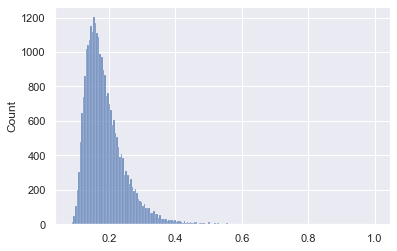

In [25]:
# 最大分钟成交量占比
import seaborn as sns
%matplotlib inline
sns.set()
sns.histplot(df_quarter['max_minutes_volume']/df_quarter['total_volume_trade'])

In [26]:
date_series=df_quarter.index.to_series().apply(lambda x:x.date()).rename('date')

<AxesSubplot:xlabel='date'>

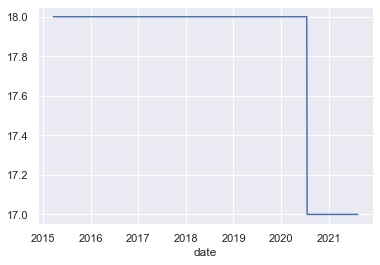

In [27]:
# 每日包含的时段数量，从结果来看无缺失
pd.DataFrame(date_series).groupby('date')['date'].count().plot()

## 一些有问题的数据

In [28]:
# 有一些奇怪的缺失值
df_concat_adj['2018-11-29 14:00':'2018-11-29 14:14']

,date,time,open,high,low,last,total_volume_trade,total_value_trade,total_position,quarter_time
datetime,,,,,,,,,,
2018-11-29 14:03:00,20181129,140300000,102.2730,102.2836,102.2730,102.2836,1173,1135988000,64592,2018-11-29 14:15:00
2018-11-29 14:04:00,20181129,140400000,102.2942,102.2942,102.2836,102.2889,126,122035950,64600,2018-11-29 14:15:00
2018-11-29 14:06:00,20181129,140600000,102.2889,102.2889,102.2889,102.2889,100,96857050,64595,2018-11-29 14:15:00
2018-11-29 14:09:00,20181129,140900000,102.3047,102.3047,102.3047,102.3047,285,276061850,64666,2018-11-29 14:15:00
2018-11-29 14:10:00,20181129,141000000,102.3047,102.3100,102.3047,102.3100,29,28093350,64677,2018-11-29 14:15:00
2018-11-29 14:11:00,20181129,141100000,102.3100,102.3153,102.3047,102.3047,76,73625900,64707,2018-11-29 14:15:00
2018-11-29 14:12:00,20181129,141200000,102.3047,102.3100,102.2836,102.2836,108,104611200,64723,2018-11-29 14:15:00
2018-11-29 14:13:00,20181129,141300000,102.2836,102.2836,102.2730,102.2836,146,141397650,64737,2018-11-29 14:15:00
2018-11-29 14:14:00,20181129,141400000,102.2836,102.3100,102.2836,102.2994,67,64899700,64738,2018-11-29 14:15:00


In [29]:
# 早上9:29会算一个几个竞价的成交数据，此处弃用
df_concat_adj.loc['2021-08-12 09'].head(3)

,date,time,open,high,low,last,total_volume_trade,total_value_trade,total_position,quarter_time
datetime,,,,,,,,,,
2021-08-12 09:29:00,20210812,92900000,110.4124,110.4124,110.4124,110.4124,197,196743900,93994,2021-08-12 09:30:00
2021-08-12 09:30:00,20210812,93000000,110.4124,110.5119,110.4124,110.5119,2203,2201231650,93713,2021-08-12 09:45:00
2021-08-12 09:31:00,20210812,93100000,110.5119,110.5230,110.4788,110.4788,865,864569000,93668,2021-08-12 09:45:00


In [30]:
df_quarter['value_num'][df_quarter['value_num'] != 15].index.to_list()



[Timestamp('2018-06-07 13:15:00'),
 Timestamp('2018-06-08 10:30:00'),
 Timestamp('2018-06-21 10:45:00'),
 Timestamp('2018-07-17 10:30:00'),
 Timestamp('2018-07-26 11:15:00'),
 Timestamp('2018-08-30 10:30:00'),
 Timestamp('2018-09-03 13:45:00'),
 Timestamp('2018-09-04 10:30:00'),
 Timestamp('2018-09-07 13:30:00'),
 Timestamp('2018-09-20 10:30:00'),
 Timestamp('2018-09-25 11:15:00'),
 Timestamp('2018-09-26 09:45:00'),
 Timestamp('2018-10-09 13:45:00'),
 Timestamp('2018-10-10 10:45:00'),
 Timestamp('2018-10-15 10:45:00'),
 Timestamp('2018-10-15 13:15:00'),
 Timestamp('2018-10-15 14:45:00'),
 Timestamp('2018-11-16 10:15:00'),
 Timestamp('2018-11-16 11:00:00'),
 Timestamp('2018-11-29 11:15:00'),
 Timestamp('2018-11-29 13:30:00'),
 Timestamp('2018-11-29 14:00:00'),
 Timestamp('2018-11-29 14:15:00'),
 Timestamp('2018-11-30 11:15:00'),
 Timestamp('2018-12-07 10:30:00'),
 Timestamp('2018-12-07 13:15:00'),
 Timestamp('2018-12-10 10:30:00'),
 Timestamp('2018-12-20 10:30:00'),
 Timestamp('2018-12-